# Ukol 1: klasifikace osob na fotce
18.6. Matyas Vondra

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Workshop/')
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /content/drive/MyDrive/Colab Notebooks/Workshop


In [4]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import splitfolders
import pathlib

In [6]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [7]:
the_labels = {
    0: "Angelina Jolie",
    1: "Brad Pitt",
    2: "Denzel Washington",
    3: "Hugh Jackman",
    4: "Jennifer Lawrence",
    5: "Johnny Depp",
    6: "Kate Winslet",
    7: "Leonardo DiCaprio",
    8: "Megan Fox",
    9: "Natalie Portman",
    10: "Nicole Kidman",
    11: "Robert Downey Jr",
    12: "Sandra Bullock",
    13: "Scarlett Johansson",
    14: "Tom Cruise",
    15: "Tom Hanks",
    16: "Will Smith"
}

In [8]:
img_height, img_width = 150, 150
input_shape = (img_height, img_width, 3)
batch_size = 32

def create_data(data_path):
    data_path = pathlib.Path(data_path)
    # rozdeleni train test v pomeru 0.8 / 0.2
    splitfolders.ratio(data_path, output='Imgs/', seed=1, ratio=(0.8, 0.2), group_prefix=None)

    # generator train obrazku vcetne rescale a augumentace
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, rotation_range = 40,
                                                                width_shift_range = 0.2, height_shift_range = 0.2,
                                                                shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True,
                                                                vertical_flip = True, fill_mode = "nearest")
    # generator test obrazku, pouze rescale
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

    train_images = train_datagen.flow_from_directory('Imgs/train/', target_size=(img_height, img_width),
                                                class_mode='categorical', batch_size=batch_size, subset='training')
    test_images = test_datagen.flow_from_directory('Imgs/val/', target_size=(img_height, img_width),
                                                class_mode='categorical', batch_size=batch_size, shuffle=False)

    return train_images, test_images

In [9]:
train_images, test_images = create_data('/content/drive/MyDrive/Colab Notebooks/Workshop/Celebrity Faces Dataset')

Copying files: 1800 files [07:58,  3.76 files/s]

Found 1440 images belonging to 17 classes.
Found 360 images belonging to 17 classes.


Angelina Jolie


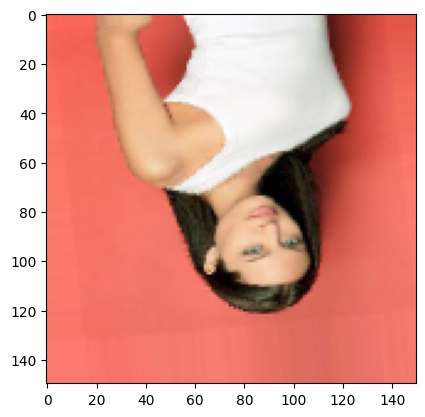

In [50]:
# kontrola augumentovaneho train obrazku s labelem
images, labels = next(train_images)
plt.imshow(images[0]) # display first image from batch
print(the_labels[np.where(labels[0] == 1)[0][0]])

Angelina Jolie


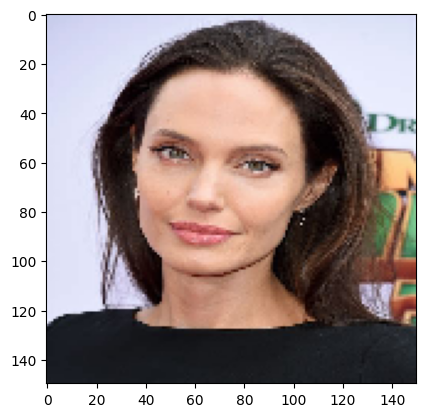

In [11]:
# kontrola test obrazku
images, labels = next(test_images)
plt.imshow(images[0]) # display first image from batch
print(the_labels[np.where(labels[0] == 1)[0][0]])

Model je zbytecne komplexni. Nevim proc, ale predikuje vzasade pouze jednu hodnotu. Ze zoufalstvi jsem zkousel pridavat ruzne vrstvy i zkusil replikovat model, ktery byl k tomuto datasetu na kegglu dostupny. Presto jsem moc neuspel. Nakonec pomohlo az zmenseni velikosti batche, model jsem ale nechal, tak jak byl.

In [56]:
# model:
model = models.Sequential()
# obrazky 150x150 se 3 barvami RGB. Filtry konvoluce jsou porad 2D (15x15)
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.GlobalAveragePooling2D())

model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(17, activation='softmax')) # 17 vystupnich kategorii


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 32)        18464     
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 32)       128       
 hNormalization)                                                 
                                                      

In [65]:
history = model.fit(train_images, epochs = 30, batch_size = 12, validation_data = test_images,
                   verbose = 1)

Epoch 1/30
45/45 [==============================] - 80s 2s/step - loss: 2.0181 - accuracy: 0.3104 - val_loss: 2.2147 - val_accuracy: 0.2500
Epoch 2/30
45/45 [==============================] - 79s 2s/step - loss: 1.9998 - accuracy: 0.3215 - val_loss: 4.0020 - val_accuracy: 0.1083
Epoch 3/30
45/45 [==============================] - 83s 2s/step - loss: 2.0272 - accuracy: 0.3222 - val_loss: 3.3736 - val_accuracy: 0.1111
Epoch 4/30
45/45 [==============================] - 79s 2s/step - loss: 2.0109 - accuracy: 0.2979 - val_loss: 2.4103 - val_accuracy: 0.2083
Epoch 5/30
45/45 [==============================] - 79s 2s/step - loss: 2.0010 - accuracy: 0.3146 - val_loss: 3.0917 - val_accuracy: 0.1250
Epoch 6/30
45/45 [==============================] - 85s 2s/step - loss: 1.9840 - accuracy: 0.3215 - val_loss: 2.3825 - val_accuracy: 0.2250
Epoch 7/30
45/45 [==============================] - 79s 2s/step - loss: 1.9675 - accuracy: 0.3444 - val_loss: 3.2455 - val_accuracy: 0.1139
Epoch 8/30
45/45 [==

In [66]:
metrics = model.evaluate(test_images)
predictions = model.predict(test_images)
predictions = tf.argmax(predictions, axis=1)
print(f"Accuracy: {metrics[1]}")

12/12 [==============================] - 6s 455ms/step
Accuracy: 0.23333333432674408


In [67]:
predictions

<tf.Tensor: shape=(360,), dtype=int64, numpy=
array([12,  9,  0,  0, 12,  9,  0,  0,  8, 12,  0,  0, 12,  0,  0,  0,  0,
        0, 12, 12,  4, 13,  6,  4,  8, 12, 12,  4, 13,  7, 12,  2, 16,  5,
        4,  1,  1, 13, 16, 12,  5,  5,  5,  2,  7,  2,  6,  2,  6,  2, 16,
        2,  2,  5,  2, 11,  2,  2,  2,  2,  8,  4,  9,  1,  4,  7,  7,  1,
        7, 11, 16,  0,  1,  5,  0,  2, 14,  0,  5,  8, 13,  9,  4,  6, 13,
        6, 13,  6, 12, 16,  6,  9,  6,  0,  9, 12,  0, 13, 12, 12,  5, 12,
       12,  9,  8, 11,  4,  4,  9, 12,  8,  6, 12, 16,  5,  0,  4,  4,  6,
        4,  6, 13,  4,  9, 13, 13, 12, 13, 13, 12,  6, 13,  6, 13, 13,  6,
        9, 12,  9, 13,  6,  7,  1,  5,  0, 16,  3,  9, 12,  2,  1, 12,  9,
        1,  1, 12,  1, 13, 12,  7, 12,  8,  8,  8,  8,  8, 12,  8, 12, 12,
        8, 12,  0,  9,  9,  8,  8,  8, 12,  8, 12,  9,  8,  6, 13,  0, 12,
        0, 13, 11, 13,  0,  0,  0, 12,  0,  0, 12, 11,  0,  6, 13,  4, 13,
        9, 13,  6, 13,  4, 11,  6,  6, 12, 13,  6,  6,

In [68]:
test_images.labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11,
       11, 11, 11, 11, 11